In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import os
os.chdir('/Users/admin/Desktop/AXA')
from wolta.data_tools import col_types
from wolta.data_tools import make_numerics

from collections import Counter
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.metrics import (classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,ConfusionMatrixDisplay
)
from imblearn.metrics import geometric_mean_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Import the given dataset

In [3]:
df=pd.read_csv('depression_data.csv')

# Dropping Name column and mapping the Target column to 1 and 0 from Yes and No

In [5]:
df.drop(['Name'], axis=1, inplace=True)
mentality_map = {'Yes': 1, 'No': 0}
df['History of Mental Illness'] = df['History of Mental Illness'].map(mentality_map)

# Feature engineering 

In [7]:
def income_range(Income):
    if Income<20000:
        return 'Low Income'
    elif (Income > 20000) & (Income<100000):
        return 'Standard Income'
    elif Income >100000:
        return 'High Income'
df['Income_Range']=df['Income'].apply(income_range) 
df['Age_bin'] = pd.cut(df['Age'], bins=[-np.inf, 18, 35, 50, 65, np.inf], labels=['Under 18', '18-35', '36-50', '51-65', '65+'])

# Label Encode all existing and new features and not the Target 

In [9]:
types = col_types(df, print_columns=False)
types = col_types(df)
loc = 0
for col in df.columns:
    if types[loc] == 'str':
        df[col] = make_numerics(df[col])
    loc += 1

# Separating features and Target columns 

In [11]:
X = df.drop('History of Mental Illness', axis=1)
y = df['History of Mental Illness']

# Creation of training data and testing data 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Data Normalization for age and income 

In [35]:
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.transform(X_test)

# Very high Recall(TPR)=59%

0:	learn: 0.6771388	total: 511ms	remaining: 2m 43s
1:	learn: 0.6765154	total: 767ms	remaining: 2m 1s
2:	learn: 0.6764637	total: 1.34s	remaining: 2m 21s
3:	learn: 0.6764472	total: 1.74s	remaining: 2m 17s
4:	learn: 0.6764422	total: 2.04s	remaining: 2m 8s
5:	learn: 0.6764085	total: 2.45s	remaining: 2m 8s
6:	learn: 0.6763969	total: 2.8s	remaining: 2m 5s
7:	learn: 0.6763883	total: 3.18s	remaining: 2m 4s
8:	learn: 0.6763613	total: 3.68s	remaining: 2m 7s
9:	learn: 0.6762697	total: 4.07s	remaining: 2m 6s
10:	learn: 0.6762452	total: 4.39s	remaining: 2m 3s
11:	learn: 0.6762258	total: 4.75s	remaining: 2m 1s
12:	learn: 0.6762068	total: 5.13s	remaining: 2m 1s
13:	learn: 0.6761820	total: 5.62s	remaining: 2m 2s
14:	learn: 0.6761623	total: 6s	remaining: 2m 1s
15:	learn: 0.6761135	total: 6.3s	remaining: 1m 59s
16:	learn: 0.6760969	total: 6.68s	remaining: 1m 59s
17:	learn: 0.6760694	total: 7.04s	remaining: 1m 58s
18:	learn: 0.6760351	total: 7.56s	remaining: 1m 59s
19:	learn: 0.6759976	total: 7.8s	remain

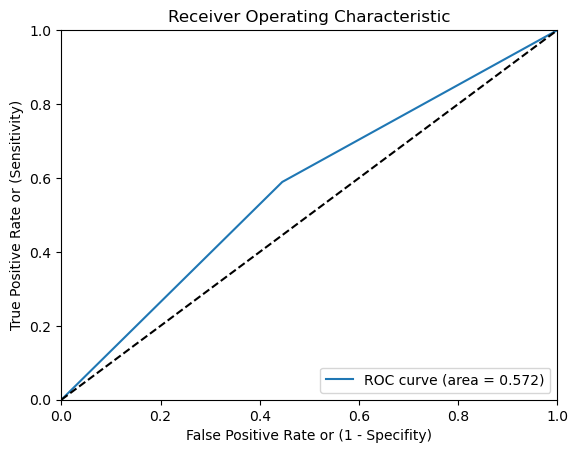

In [37]:
impor]\7t sklearn.metrics as metrics
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
cat=CatBoostClassifier(n_estimators=320, max_depth=3, learning_rate=1,class_weights=class_weight_dict)
cat.fit(X_train_scaled, y_train)
y_pred = cat.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
G_score = geometric_mean_score(y_test, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix (original predictions):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (original predictions):")
print(classification_report(y_test, y_pred))
print('The weighted f1 score for the testing data:', f1)
print('The weighted G_score for the testing data:', G_score)
print('AUC = %.2f' % roc_auc_score(y_test, y_pred))  #1

metrics.roc_curve(y_pred, y_test)
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Hyperparameter Tuning by Bayesian Optimization

In [27]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
space = {'learning_rate': hp.choice('learning_rate', [0.1,0.5,0.02,0.05,0.0001]),

        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [ ]:
# Scoring function for Hyperparameter Tuning 

In [ ]:
from sklearn.metrics import make_scorer, precision_score,recall_score,f1_score
scoring={'recall': make_scorer(recall_score),
         'f1_score': make_scorer(f1_score)}

In [39]:
def objective(space):
    model = CatBoostClassifier(learning_rate = space['learning_rate'],n_estimators = space['n_estimators'],class_weights=class_weight_dict)
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv = 2).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [41]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 4,
            trials= trials)

0:	learn: 0.6805354	total: 335ms	remaining: 3.02s                               

1:	learn: 0.6771959	total: 748ms	remaining: 2.99s                               

2:	learn: 0.6762032	total: 1.14s	remaining: 2.67s                               

3:	learn: 0.6757297	total: 1.56s	remaining: 2.33s                               

4:	learn: 0.6756575	total: 1.85s	remaining: 1.85s                               

5:	learn: 0.6754389	total: 2.25s	remaining: 1.5s                                

6:	learn: 0.6752440	total: 2.63s	remaining: 1.13s                               

7:	learn: 0.6750329	total: 3.15s	remaining: 788ms                               

8:	learn: 0.6748824	total: 3.5s	remaining: 389ms                                

9:	learn: 0.6747160	total: 3.92s	remaining: 0us                                 

0:	learn: 0.6808948	total: 406ms	remaining: 3.65s                               

1:	learn: 0.6774648	total: 929ms	remaining: 3.72s                               

2:	learn: 0.6765

# Model with  F-1 score 62.19% , AUC 0.574,  Average Recall 48%

Accuracy: 0.6125
Precision: 0.6367
Recall: 0.6125
F1 Score: 0.6219
Confusion Matrix (original predictions):
[[38650 18860]
 [13211 12033]]

Classification Report (original predictions):
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     57510
           1       0.39      0.48      0.43     25244

    accuracy                           0.61     82754
   macro avg       0.57      0.57      0.57     82754
weighted avg       0.64      0.61      0.62     82754

The weighted f1 score for the testing data: 0.6219445782677434
The weighted G_score for the testing data: 0.5730978858918655


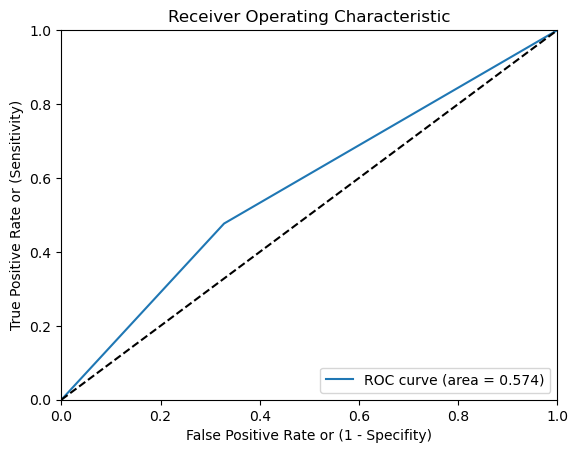

In [19]:
from sklearn import svm
from sklearn import linear_model
import sklearn.metrics as metrics

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
est = svm.LinearSVC(loss ='squared_hinge' ,penalty='l1',random_state=0,max_iter=1000000, C=1,class_weight=class_weight_dict)

est.fit(X_train_scaled, y_train)
y_pred = est.predict(X_test_scaled)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
G_score = geometric_mean_score(y_test, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix (original predictions):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (original predictions):")
print(classification_report(y_test, y_pred))
print('The weighted f1 score for the testing data:', f1)
print('The weighted G_score for the testing data:', G_score)


metrics.roc_curve(y_pred, y_test)
plt.show()

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

Accuracy: 0.6179
Precision: 0.6368
Recall: 0.6179
F1 Score: 0.6257
Confusion Matrix (original predictions):
[[39465 18045]
 [13578 11666]]

Classification Report (original predictions):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     57510
           1       0.39      0.46      0.42     25244

    accuracy                           0.62     82754
   macro avg       0.57      0.57      0.57     82754
weighted avg       0.64      0.62      0.63     82754

The weighted f1 score for the testing data: 0.6256779613448248


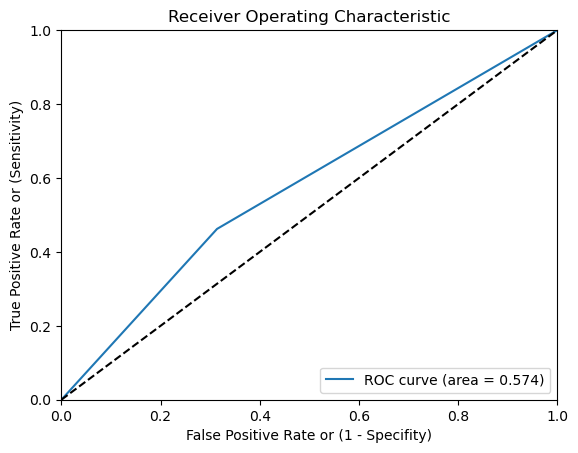

In [49]:
sgd=SGDClassifier(penalty="elasticnet", alpha=0.0001, l1_ratio=0.15,max_iter=1000, tol=1e-3, class_weight=class_weight_dict,random_state=42)
sgd.fit(X_train_scaled, y_train)
# Make predictions
y_pred = sgd.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix (original predictions):")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (original predictions):")
print(classification_report(y_test, y_pred))
print('The weighted f1 score for the testing data:', f1)

metrics.roc_curve(y_pred, y_test)
plt.show()

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Model performance validation using KFold 

In [ ]:
f1_score_per_fold=[]
Labels=y.to_frame()
fold=0
# Having 5 folds allows us to have the exact match of train and test row counts as per our intial model training was on
skf = KFold(n_splits=3,shuffle=True,random_state=100)
for f, (t_,v_) in enumerate(skf.split(X=df, y=np.array(Labels))):
    fold =fold +1
    X=pd.DataFrame(X)
    y=pd.DataFrame(y)
    df_train = X.loc[t_]
    df_test = X.loc[v_]
    label_train=y.loc[t_]
    label_test=y.loc[v_]
    df_train=np.array(df_train)
    df_test=np.array(df_test)
    label_train=np.array(label_train)
    label_test=np.array(label_test)
    print('-------------------------------------------------------')
    print('Training for fold:',fold)
    print('Total Training rows:',df_train.shape[0])
    print('Total Testing rows:',df_test.shape[0])
    model.fit(df_train, label_train)
    y_pred = model.predict(df_test)
    score = f1_score(label_test, y_pred,average='weighted')
    print('The f1_score for this fold',round(score*100,2))
    f1_score_per_fold.append(round(score*100,2))
    if (fold==skf.get_n_splits(X=df, y=y)):
        print('----------------------------------------------------------')
        print('mean f1_score for all folds:',np.mean(f1_score_per_fold))

-------------------------------------------------------
Training for fold: 1
Total Training rows: 275845
Total Testing rows: 137923


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Get the environment details

In [47]:
%pip freeze

absl-py==2.1.0
aext-assistant @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_e8wd_39o7u/croot/aext-assistant_1734643594996/work
aext-assistant-server @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_11co_dx32p/croot/aext-assistant-server_1734640107264/work
aext-core @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_abh4583law/croot/aext-core_1734637785810/work
aext-core-server @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b5dgq8d0kd/croot/aext-core-server_1734635062953/work
aext-panels @ file:///private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_da4npqhdda/croot/aext-panels_1734642945557/work
aext-panels-server @ file:///private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_c7k0q592nv/croot/aext-panels-server_1734639713336/work
aext-project-filebrowser-server @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_71g16r1gvy/croot/aext-project-filebrowser-server_17346879